# Analysis of human and model behavior across physical domains

**The purpose of this notebook is to:** 
* Apply preprocessing to human behavioral data
* Visualize distribution and compute summary statistics over **human** physical judgments
* Visualize distribution and compute summary statistics over **model** physical judgments
* Conduct human-model comparisons
* Output CSV that can be re-loaded into R notebook for statistical modeling & fancy visualizations

**This notebook depends on:**
* Running `./generate_dataframes.py` (INTERNAL USE ONLY)
* Running `./upload_results.py` (INTERNAL USE ONLY)
* Running `./download_results.py` (PUBLIC USE)

## setup

#### Load packages

In [1]:
import os
import sys
import urllib, io

sys.path.append('./analysis_helpers')
from importlib import reload

import numpy as np
import scipy.stats as stats
import pandas as pd

import analysis_helpers as h

import pymongo as pm
from collections import Counter
import json
import re
import ast

from PIL import Image, ImageOps, ImageDraw, ImageFont 

from io import BytesIO
import base64

from tqdm.notebook import tqdm

import  matplotlib
from matplotlib import pylab, mlab, pyplot
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.core.pylabtools import figsize, getfigs
plt = pyplot
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
plt.style.use('seaborn-white')

import seaborn as sns

%matplotlib inline
import scipy.stats
import sklearn.metrics
import random

from IPython.display import clear_output

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

#### options

In [2]:
# display all columns
pd.set_option('display.max_columns', None)

# seaborn plotting themes
sns.set_context('talk')
sns.set_style("whitegrid")

#### set up paths and directories

In [3]:
## directory & file hierarchy
proj_dir = os.path.abspath('..')
datavol_dir = os.path.join(proj_dir,'data')
analysis_dir =  os.path.abspath('.')
results_dir = os.path.join(proj_dir,'results')
plot_dir = os.path.join(results_dir,'plots')
csv_dir = os.path.join(results_dir,'csv')
json_dir = os.path.join(results_dir,'json')
exp_dir = os.path.abspath(os.path.join(proj_dir,'behavioral_experiments'))
png_dir = os.path.abspath(os.path.join(datavol_dir,'png'))

## add helpers to python path
if os.path.join(proj_dir,'stimuli') not in sys.path:
    sys.path.append(os.path.join(proj_dir,'stimuli'))
    
if not os.path.exists(results_dir):
    os.makedirs(results_dir)
    
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)   
    
if not os.path.exists(csv_dir):
    os.makedirs(csv_dir)       
    
## add helpers to python path
if os.path.join(analysis_dir,'utils') not in sys.path:
    sys.path.append(os.path.join(analysis_dir,'utils'))   

def make_dir_if_not_exists(dir_name):   
    if not os.path.exists(dir_name):
        os.makedirs(dir_name)
    return dir_name

## create directories that don't already exist        
result = [make_dir_if_not_exists(x) for x in [results_dir,plot_dir,csv_dir]]

### load human data

In [4]:
from experiment_meta import *
HEM = pd.DataFrame(NEURIPS2021_EXPS) # HEM = "human experiment metadata"
HEM

,study,bucket_name,stim_version,iterationName
0,dominoes_pilot,human-physics-benchmarking-dominoes-pilot,production_1,production_1_testing
1,collision_pilot,human-physics-benchmarking-collision-pilot,production_2,production_2_testing
2,towers_pilot,human-physics-benchmarking-towers-pilot,production_2,production_2_testing
3,linking_pilot,human-physics-benchmarking-linking-pilot,production_2,production_2_testing
4,containment_pilot,human-physics-benchmarking-containment-pilot,production_2,production_2_testing
5,rollingsliding_pilot,human-physics-benchmarking-rollingsliding-pilot,production_2,production_2_testing
6,drop_pilot,human-physics-benchmarking-drop-pilot,production_2,production_2_testing
7,clothiness_pilot,human-physics-benchmarking-clothiness-pilot,production_2,production_2_testing


In [5]:
## get paths to all human response data
data_paths = [os.path.join(csv_dir,'humans',i) for i in os.listdir(os.path.join(csv_dir,'humans'))]
resp_paths = [i for i in data_paths if i.split('/')[-1].split('-')[0]=='human_responses']
assert len(resp_paths)==8

In [6]:
## also load all human data into a big dataframe
HD = pd.concat([h.load_and_preprocess_data(p) for p in resp_paths])
print("Loaded {} lines".format(len(HD)))

Loaded 120450 lines


### load model data

In [7]:
## get paths to all model data
model_data_paths = [os.path.join(csv_dir,'models',i) for i in os.listdir(os.path.join(csv_dir,'models'))]
model_res_paths = [i for i in model_data_paths if i.split('.')[-1] == "csv"]

In [8]:
## load all model results into a single dataframe
MD = pd.concat([pd.read_csv(p).assign(filename=p.split('/')[-1]) for p in model_res_paths])
print("Loaded {} rows".format(len(MD)))

Loaded 10194 rows


In [9]:
# a couple of import steps (restore original scenario names, add single prediction value, add correctness column)
MD = h.process_model_dataframe(MD)

### generate summary table of human 95% CIs for accuracy across all scenarios

In [10]:
## init human_bootstrapped_accuracy for plotting
human_bootstrapped_accuracy = pd.DataFrame()

for exp_ind, exp_name in enumerate(resp_paths):
    
    ## get path to response data
    path_to_data = resp_paths[exp_ind]

    ## load data and apply preprocessing
    _D = h.load_and_preprocess_data(path_to_data)
    scenarioName = _D.scenarioName.values[0]
    print('Currently analyzing the {} experiment.'.format(_D.scenarioName.values[0]))
    clear_output(wait=True)
    
    ## apply exclusion criteria
    D = h.apply_exclusion_criteria(_D)

    ## compute bootstrapped sampling distributions of accuracy
    Dacc = D.groupby('prolificIDAnon').agg({'correct':np.mean})
    bootmeans = h.bootstrap_mean(Dacc, col='correct', nIter=1000)

    obsmean = np.mean(Dacc.correct.values)
    bootmean = np.mean(bootmeans)
    lb = np.percentile(bootmeans,2.5)
    ub = np.percentile(bootmeans,97.5)
    pct25 = np.percentile(Dacc,2.5)
    pct975 = np.percentile(Dacc,97.5)
    ## merge bootstrapped accuracy estimates
    if len(human_bootstrapped_accuracy)==0:
        human_bootstrapped_accuracy = pd.DataFrame(['human', scenarioName, obsmean,bootmean,lb,ub, pct25, pct975]).transpose()
    else:
        human_bootstrapped_accuracy = pd.concat([human_bootstrapped_accuracy, pd.DataFrame(['human', scenarioName, obsmean,bootmean,lb,ub, pct25, pct975]).transpose()],axis=0)
        
## add column names        
human_bootstrapped_accuracy.columns=['agent','scenario','obs_mean', 'boot_mean', 'ci_lb', 'ci_ub', 'pct_2.5', 'pct_97.5']

## save out human_bootstrapped_accuracy to re-plot in R
if not os.path.exists(os.path.join(csv_dir, 'summary')):
    os.makedirs(os.path.join(csv_dir, 'summary'))    
human_bootstrapped_accuracy.to_csv(os.path.join(csv_dir, 'summary','human_accuracy_by_scenario.csv'), index=False)
print('Saved to file! Done.')

Saved to file! Done.


In [11]:
human_bootstrapped_accuracy

,agent,scenario,obs_mean,boot_mean,ci_lb,ci_ub,pct_2.5,pct_97.5
0,human,collision,0.807333,0.807273,0.79748,0.816963,0.703,0.88
0,human,rollingsliding,0.882986,0.882948,0.875411,0.890696,0.789167,0.94
0,human,dominoes,0.692791,0.6927,0.684341,0.701163,0.614167,0.76
0,human,drop,0.743656,0.743722,0.73541,0.751326,0.666667,0.804667
0,human,clothiness,0.678133,0.678222,0.663729,0.692269,0.543667,0.771667
0,human,linking,0.643182,0.643234,0.631968,0.654545,0.536833,0.744333
0,human,containment,0.766988,0.766892,0.758072,0.775026,0.686667,0.839667
0,human,towers,0.763137,0.763012,0.754975,0.770982,0.669333,0.826


### Human-human consistency across stimuli (within scenario)
We will analyze human-human consistency by computing the mean correlation between (binary) response vectors produced by each human participant across all stimuli within each scenario. 



#### Correlation

In [12]:
## init human_boot_corr for plotting
human_boot_corr = pd.DataFrame()

for exp_ind, exp_name in enumerate(resp_paths):
    
    ## get path to response data
    path_to_data = resp_paths[exp_ind]

    ## load data and apply preprocessing
    _D = h.load_and_preprocess_data(path_to_data)
    scenarioName = _D.scenarioName.values[0]
    print('Currently analyzing the {} experiment.'.format(_D.scenarioName.values[0]))
    clear_output(wait=True)

    ## apply exclusion criteria
    D = h.apply_exclusion_criteria(_D)
    
    ## create response feature matrix (numSubs x numTrialsPerSub)
    D2 = D.sort_values(by=['prolificIDAnon','stim_ID']).reset_index(drop=True)
    numSubs = len(np.unique(D['prolificIDAnon'].values))
    numTrialsPerSub = int(len(D)/numSubs)
    respMat = np.reshape(D2['responseBool'].values, (numSubs,numTrialsPerSub)) 

    ## sanity check that the reshape operation happened correctly
    assert len([i for (i,j) in list(zip(respMat[0],D2[:150]['responseBool'].values)) if i!=j])==0    
    
    ## get pairwise correlations
    dists = 1-scipy.spatial.distance.pdist(respMat, metric='correlation')
    corrMat = scipy.spatial.distance.squareform(dists)
    
    ## get percentiles over pairwise corrs
    pairwiseCorrs = corrMat[np.triu_indices(n=len(corrMat), k=1)]
    lb = np.percentile(pairwiseCorrs, 2.5)
    med = np.percentile(pairwiseCorrs, 50)
    ub = np.percentile(pairwiseCorrs, 97.5)  
        
    if len(human_boot_corr)==0:
        human_boot_corr = pd.DataFrame(['human', scenarioName, lb, med, ub]).transpose()
    else:
        human_boot_corr = pd.concat([human_boot_corr, pd.DataFrame(['human', scenarioName, lb, med, ub]).transpose()],axis=0)
        
## add column names        
human_boot_corr.columns=['agent','scenario','corr_lb', 'corr_med', 'corr_ub']

## save out human_boot_corr to re-plot in R
if not os.path.exists(os.path.join(csv_dir, 'summary')):
    os.makedirs(os.path.join(csv_dir, 'summary'))    
human_boot_corr.to_csv(os.path.join(csv_dir, 'summary','human_pairwiseCorrs_by_scenario.csv'), index=False)
print('Saved to file! Done.')

Saved to file! Done.


In [13]:
human_boot_corr

,agent,scenario,corr_lb,corr_med,corr_ub
0,human,collision,0.388046,0.62822,0.776057
0,human,rollingsliding,0.506253,0.713836,0.851243
0,human,dominoes,0.231102,0.425943,0.591814
0,human,drop,0.266334,0.501544,0.681139
0,human,clothiness,0.065426,0.349287,0.549326
0,human,linking,0.114636,0.386807,0.569892
0,human,containment,0.306122,0.559038,0.725013
0,human,towers,0.299731,0.565581,0.725722


#### Cohen's $\kappa$

In [14]:
## init human_boot_cohenk for plotting
human_boot_cohenk = pd.DataFrame()

for exp_ind, exp_name in enumerate(resp_paths):
    
    ## get path to response data
    path_to_data = resp_paths[exp_ind]

    ## load data and apply preprocessing
    _D = h.load_and_preprocess_data(path_to_data)
    scenarioName = _D.scenarioName.values[0]
    print('Currently analyzing the {} experiment.'.format(_D.scenarioName.values[0]))
    clear_output(wait=True)

    ## apply exclusion criteria
    D = h.apply_exclusion_criteria(_D)
    
    ## create response feature matrix (numSubs x numTrialsPerSub)
    D2 = D.sort_values(by=['prolificIDAnon','stim_ID']).reset_index(drop=True)
    numSubs = len(np.unique(D['prolificIDAnon'].values))
    numTrialsPerSub = int(len(D)/numSubs)
    respMat = np.reshape(D2['responseBool'].values, (numSubs,numTrialsPerSub)) 

    ## sanity check that the reshape operation happened correctly
    assert len([i for (i,j) in list(zip(respMat[0],D2[:150]['responseBool'].values)) if i!=j])==0    
      
    ## compute Cohen's kappa
    ## with a horrific double loop
    kappas = []
    for i in range(respMat.shape[0]): # for each participant
        for j in range(i+1,respMat.shape[0]): # compare to every participant after them
            assert i != j
            kappa = sklearn.metrics.cohen_kappa_score(respMat[i],respMat[j])
            kappas.append(kappa)
    
    ## get percentiles over pairwise corrs
    lb = np.percentile(kappas, 2.5)
    med = np.percentile(kappas, 50)
    ub = np.percentile(kappas, 97.5)  
        
    if len(human_boot_cohenk)==0:
        human_boot_cohenk = pd.DataFrame(['human', scenarioName, lb, med, ub]).transpose()
    else:
        human_boot_cohenk = pd.concat([human_boot_cohenk, pd.DataFrame(['human', scenarioName, lb, med, ub]).transpose()],axis=0)
        
## add column names        
human_boot_cohenk.columns=['agent','scenario','corr_lb', 'corr_med', 'corr_ub']

## save out human_boot_cohenk to re-plot in R
if not os.path.exists(os.path.join(csv_dir, 'summary')):
    os.makedirs(os.path.join(csv_dir, 'summary'))    
human_boot_cohenk.to_csv(os.path.join(csv_dir, 'summary','human_pairwiseCohensKs_by_scenario.csv'), index=False)
print('Saved to file! Done.')

Saved to file! Done.


In [15]:
human_boot_cohenk

,agent,scenario,corr_lb,corr_med,corr_ub
0,human,collision,0.379922,0.618529,0.773083
0,human,rollingsliding,0.490152,0.707031,0.85095
0,human,dominoes,0.210147,0.410819,0.585372
0,human,drop,0.260437,0.494367,0.678875
0,human,clothiness,0.062416,0.340571,0.542955
0,human,linking,0.109512,0.369462,0.560538
0,human,containment,0.284806,0.546667,0.719987
0,human,towers,0.285117,0.549918,0.720673


## Visualize distribution of model physical judgments, by domain

In [16]:
MD_by_model = MD.groupby(['filename','Readout Test Data','Model','Dynamics Training Dataset','Readout Type']).agg({'correct':'mean'})
MD_by_model

correct
filename                    Readout Test Data Model Dynamics Training Dataset Readout Type          
debug-dataframe-results.csv clothiness        CSWM  all                       A             0.680000
                                                                              B             0.535000
                                                                              C             0.545000
                                                    clothiness                A             0.480000
                                                                              B             0.450000
                                                                              C             0.410000
                            collision         CSWM  all                       A             0.570833
                                                                              B             0.566667
                                                                              C             0.566667
                                                    collision                 A             0.550000
                                                                              B             0.508333
                                                                              C             0.495833
                            containment       CSWM  all                       A             0.600000
                                                                              B             0.551220
                                                                              C             0.595122
                                                    containment               A             0.604878
                                                                              B             0.624390
                                                                              C             0.575610
                            dominoes          CSWM  all                       A             0.429603
                                                                              B             0.411552
                                                                              C             0.404332
                                                    dominoes                  A             0.574007
                                                                              B             0.469314
                                                                              C             0.451264
                            drop              CSWM  all                       A             0.620000
                                                                              B             0.565000
                                                                              C             0.550000
                                                    drop                      A             0.645000
                                                                              B             0.600000
                                                                              C             0.595000
                            linking           CSWM  all                       A             0.653659
                                                                              B             0.629268
                                                                              C             0.609756
                                                    linking                   A             0.639024
                                                                              B             0.673171
                                                                              C             0.663415
                            rollingsliding    CSWM  all                       A             0.472527
                                                                              B             0.423077
                                                     

## Compute summary statistics over model physical judgments, by domain

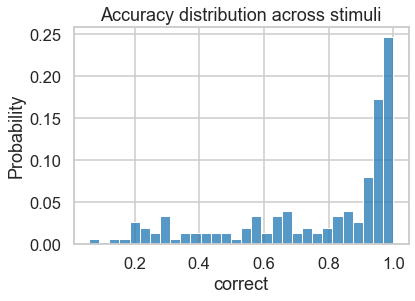

In [17]:
Dacc = D.groupby('stim_ID').agg({'correct':np.mean})
p = sns.histplot(data=Dacc, x='correct', bins=30, stat='probability')
t = plt.title('Accuracy distribution across stimuli')

## Conduct human-model comparisons
We will compare human and model behavior in two ways: **absolute performance** and **response pattern.**

#### **Absolute Performance** 
We will compare the accuracy of each model to the mean accuracy of humans, for each scenario. 
To do this, we will first compute estimates of mean human accuracy for each scenario and construct 95% confidence intervals for each of these estimates. 
These confidence intervals will be constructed by bootstrapping: specifically, for an experiment with N participants, we will resample N participants with replacement and compute the proportion correct for that bootstrapped sample. We will take repeat this resampling procedure 1000 times to generate a sampling distribution for the mean proportion correct. The 2.5th and 97.5th percentile will be extracted from this sampling distribution to provide the lower and upper bounds of the 95% confidence interval.

For each model, we will then compare their proportion correct (a point estimate) to the human confidence interval. 

In [18]:
# group model data by scenario
MD_by_scenario = MD.groupby(['Readout Test Data','ModelID']).agg(
{
    'correct':'mean'
})

In [19]:
accuracies = {}

for scenario in sorted(MD['Readout Test Data'].unique()):
    print("Now running scenario",scenario)
    _MD_by_scenario = MD_by_scenario.loc[[scenario]]
    for _,model_row in list(_MD_by_scenario.iterrows()):
        #each model is one row of MD
        human_row = human_bootstrapped_accuracy.query("scenario == @scenario")
        assert len(model_row) == len(human_row) == 1
        correct_ratio = model_row['correct']/human_row['boot_mean']
        correct_diff = model_row['correct'] - human_row['boot_mean']
        accuracies[(scenario,model_row.name[1])] = {'ratio': float(correct_ratio), 
                                                    'diff': float(correct_diff),
                                                    'human_correct': float(human_row['boot_mean']),
                                                    'model_correct': float(model_row['correct'])}
    clear_output(wait=True)

model_human_accuracies = pd.DataFrame(accuracies).transpose()  
model_human_accuracies.to_csv(os.path.join(csv_dir, 'summary','model_human_accuracies.csv'), index=False)
print('Saved to file. Done!')

Saved to file. Done!


In [20]:
model_human_accuracies

ratio  \
clothiness     CSWM_CSWM encoder_Contrastive_all_CSWM dynamics...  1.002621   
               CSWM_CSWM encoder_Contrastive_all_CSWM dynamics...  0.788827   
               CSWM_CSWM encoder_Contrastive_all_CSWM dynamics...  0.803571   
               CSWM_CSWM encoder_Contrastive_clothiness_CSWM d...  0.707733   
               CSWM_CSWM encoder_Contrastive_clothiness_CSWM d...  0.663499   
               CSWM_CSWM encoder_Contrastive_clothiness_CSWM d...  0.604522   
collision      CSWM_CSWM encoder_Contrastive_all_CSWM dynamics...  0.707113   
               CSWM_CSWM encoder_Contrastive_all_CSWM dynamics...  0.701952   
               CSWM_CSWM encoder_Contrastive_all_CSWM dynamics...  0.701952   
               CSWM_CSWM encoder_Contrastive_collision_CSWM dy...  0.681306   
               CSWM_CSWM encoder_Contrastive_collision_CSWM dy...  0.629692   
               CSWM_CSWM encoder_Contrastive_collision_CSWM dy...  0.614208   
containment    CSWM_CSWM encoder_Contrastive_all_CSWM dynamics...  0.782378   
               CSWM_CSWM encoder_Contrastive_all_CSWM dynamics...  0.718770   
               CSWM_CSWM encoder_Contrastive_all_CSWM dynamics...  0.776018   
               CSWM_CSWM encoder_Contrastive_containment_CSWM ...  0.788739   
               CSWM_CSWM encoder_Contrastive_containment_CSWM ...  0.814182   
               CSWM_CSWM encoder_Contrastive_containment_CSWM ...  0.750574   
dominoes       CSWM_CSWM encoder_Contrastive_all_CSWM dynamics...  0.620186   
               CSWM_CSWM encoder_Contrastive_all_CSWM dynamics...  0.594128   
               CSWM_CSWM encoder_Contrastive_all_CSWM dynamics...  0.583705   
               CSWM_CSWM encoder_Contrastive_dominoes_CSWM dyn...  0.828652   
               CSWM_CSWM encoder_Contrastive_dominoes_CSWM dyn...  0.677514   
               CSWM_CSWM encoder_Contrastive_dominoes_CSWM dyn...  0.651456   
drop           CSWM_CSWM encoder_Contrastive_all_CSWM dynamics...  0.833645   
               CSWM_CSWM encoder_Contrastive_all_CSWM dynamics...  0.759693   
               CSWM_CSWM encoder_Contrastive_all_CSWM dynamics...  0.739524   
               CSWM_CSWM encoder_Contrastive_drop_CSWM dynamic...  0.867260   
               CSWM_CSWM encoder_Contrastive_drop_CSWM dynamic...  0.806753   
               CSWM_CSWM encoder_Contrastive_drop_CSWM dynamic...  0.800030   
linking        CSWM_CSWM encoder_Contrastive_all_CSWM dynamics...  1.016207   
               CSWM_CSWM encoder_Contrastive_all_CSWM dynamics...  0.978289   
               CSWM_CSWM encoder_Contrastive_all_CSWM dynamics...  0.947954   
               CSWM_CSWM encoder_Contrastive_linking_CSWM dyna...  0.993456   
               CSWM_CSWM encoder_Contrastive_linking_CSWM dyna...  1.046541   
               CSWM_CSWM encoder_Contrastive_linking_CSWM dyna...  1.031374   
rollingsliding CSWM_CSWM encoder_Contrastive_all_CSWM dynamics...  0.535170   
               CSWM_CSWM encoder_Contrastive_all_CSWM dynamics...  0.479164   
               CSWM_CSWM encoder_Contrastive_all_CSWM dynamics...  0.504056   
               CSWM_CSWM encoder_Contrastive_rollingsliding_CS...  0.572508   
               CSWM_CSWM encoder_Contrastive_rollingsliding_CS...  0.566285   
               CSWM_CSWM encoder_Contrastive_rollingsliding_CS...  0.516501   
towers         CSWM_CSWM encoder_Contrastive_all_CSWM dynamics...  1.048477   
               CSWM_CSWM encoder_Contrastive_all_CSWM dynamics...  0.966565   
               CSWM_CSWM encoder_Contrastive_all_CSWM dynamics...  0.933800   
               CSWM_CSWM encoder_Contrastive_towers_CSWM dynam...  1.037555   
               CSWM_CSWM encoder_Contrastive_towers_CSWM dynam...  0.884652   
               CSWM_CSWM encoder_Contrastive_towers_CSWM dynam...  0.944721   

                                                                       diff  \
clothiness     CSWM_CSWM encoder_Contrastive_all_CSWM dynamics...  0.001778   
               CSWM_CSWM encoder_Contras

#### **Response Pattern**
We will compare the pattern of predictions generated by each model to the pattern of predictions generated by humans. 

We will do this by using two standard inter-rater reliability metrics:
##### **Correlation**
For each pair of human participants, we will compute the correlation between their (binary) response vectors, yielding a distribution of pairwise human-human correlations. 
For each model, we will compute the correlation between its response vector and every human participant, as well as every other model. 
A model's response pattern will be considered more similar to humans' insofar as the mean model-human correlation (across humans) lies closer to the mean human-human correlation (for all pairs of humans).

In [31]:
out_dict = {}

for scenario in sorted(MD['Readout Test Data'].unique()):
    print("Now running scenario",scenario)
    _MD = MD[MD['Readout Test Data'] == scenario]
    _HD = HD[HD['scenarioName'] == scenario]
    for model in _MD['ModelID'].unique():
        measures_for_model = []
        #get responses of model        
        _MD_model = _MD[_MD['ModelID'] == model]
        _MD_model = _MD_model.sort_values('Canon Stimulus Name') #ensure same stim order
        #iterate over the 100 or so participants
        for gameID in _HD['gameID'].unique():
            #get one game
            _HD_game = _HD[_HD['gameID']==gameID]
            #ensure stim order
            _HD_game = _HD_game.sort_values('stim_ID')
            #in case the models have more or less responses compared to humans
            human_stim_names = list(_HD_game['stim_ID'])
            model_stim_names = list(_MD_model['Canon Stimulus Name'])
            joint_stim_names = set(human_stim_names).intersection(set(model_stim_names))
            if len(human_stim_names) > len(joint_stim_names):
                print("⚠️ {} is missing data on human responses".format(model))
            #subset both models to ensure only common stims are used
            _MD_model = _MD_model[_MD_model['Canon Stimulus Name'].isin(joint_stim_names)]            
            _HD_game = _HD_game[_HD_game['stim_ID'].isin(joint_stim_names)]
            #pull response vector
            human_responses = np.array(_HD_game['responseBool'].astype(int)) #get human response and cast to int
            model_responses = np.array(_MD_model['Predicted Outcome'])
#             assert list(model_stim_names) == list(human_stim_names), "experimental and test stims don't match"
            # compute correlation
            measure = scipy.spatial.distance.correlation(model_responses,human_responses, centered=False)
            measures_for_model.append(measure)
        # get percentiles over the range of measures
        lb = np.percentile(measures_for_model, 2.5)
        med = np.percentile(measures_for_model, 50)
        ub = np.percentile(measures_for_model, 97.5)
        out_dict[(scenario, model)] = {'scenario':scenario,
                                       'modelID':model,
                                       'corr_lb':lb,
                                       'corr_med':med,
                                       'corr_ub':ub,}
        clear_output(wait=True)

model_human_correlations = pd.DataFrame(out_dict).transpose()  
model_human_correlations.to_csv(os.path.join(csv_dir, 'summary','model_human_correlations.csv'), index=False)
print('Saved to file. Done!')

Saved to file. Done!


In [32]:
model_human_correlations

scenario  \
clothiness     CSWM_CSWM encoder_Contrastive_all_CSWM dynamics...      clothiness   
               CSWM_CSWM encoder_Contrastive_all_CSWM dynamics...      clothiness   
               CSWM_CSWM encoder_Contrastive_all_CSWM dynamics...      clothiness   
               CSWM_CSWM encoder_Contrastive_clothiness_CSWM d...      clothiness   
               CSWM_CSWM encoder_Contrastive_clothiness_CSWM d...      clothiness   
               CSWM_CSWM encoder_Contrastive_clothiness_CSWM d...      clothiness   
collision      CSWM_CSWM encoder_Contrastive_all_CSWM dynamics...       collision   
               CSWM_CSWM encoder_Contrastive_all_CSWM dynamics...       collision   
               CSWM_CSWM encoder_Contrastive_all_CSWM dynamics...       collision   
               CSWM_CSWM encoder_Contrastive_collision_CSWM dy...       collision   
               CSWM_CSWM encoder_Contrastive_collision_CSWM dy...       collision   
               CSWM_CSWM encoder_Contrastive_collision_CSWM dy...       collision   
containment    CSWM_CSWM encoder_Contrastive_all_CSWM dynamics...     containment   
               CSWM_CSWM encoder_Contrastive_all_CSWM dynamics...     containment   
               CSWM_CSWM encoder_Contrastive_all_CSWM dynamics...     containment   
               CSWM_CSWM encoder_Contrastive_containment_CSWM ...     containment   
               CSWM_CSWM encoder_Contrastive_containment_CSWM ...     containment   
               CSWM_CSWM encoder_Contrastive_containment_CSWM ...     containment   
dominoes       CSWM_CSWM encoder_Contrastive_all_CSWM dynamics...        dominoes   
               CSWM_CSWM encoder_Contrastive_all_CSWM dynamics...        dominoes   
               CSWM_CSWM encoder_Contrastive_all_CSWM dynamics...        dominoes   
               CSWM_CSWM encoder_Contrastive_dominoes_CSWM dyn...        dominoes   
               CSWM_CSWM encoder_Contrastive_dominoes_CSWM dyn...        dominoes   
               CSWM_CSWM encoder_Contrastive_dominoes_CSWM dyn...        dominoes   
drop           CSWM_CSWM encoder_Contrastive_all_CSWM dynamics...            drop   
               CSWM_CSWM encoder_Contrastive_all_CSWM dynamics...            drop   
               CSWM_CSWM encoder_Contrastive_all_CSWM dynamics...            drop   
               CSWM_CSWM encoder_Contrastive_drop_CSWM dynamic...            drop   
               CSWM_CSWM encoder_Contrastive_drop_CSWM dynamic...            drop   
               CSWM_CSWM encoder_Contrastive_drop_CSWM dynamic...            drop   
linking        CSWM_CSWM encoder_Contrastive_all_CSWM dynamics...         linking   
               CSWM_CSWM encoder_Contrastive_all_CSWM dynamics...         linking   
               CSWM_CSWM encoder_Contrastive_all_CSWM dynamics...         linking   
               CSWM_CSWM encoder_Contrastive_linking_CSWM dyna...         linking   
               CSWM_CSWM encoder_Contrastive_linking_CSWM dyna...         linking   
               CSWM_CSWM encoder_Contrastive_linking_CSWM dyna...         linking   
rollingsliding CSWM_CSWM encoder_Contrastive_all_CSWM dynamics...  rollingsliding   
               CSWM_CSWM encoder_Contrastive_all_CSWM dynamics...  rollingsliding   
               CSWM_CSWM encoder_Contrastive_all_CSWM dynamics...  rollingsliding   
               CSWM_CSWM encoder_Contrastive_rollingsliding_CS...  rollingsliding   
               CSWM_CSWM encoder_Contrastive_rollingsliding_CS...  rollingsliding   
               CSWM_CSWM encoder_Contrastive_rollingsliding_CS...  rollingsliding   
towers         CSWM_CSWM encoder_Contrastive_all_CSWM dynamics...          towers   
               CSWM_CSWM encoder_Contrastive_all_CSWM dynamics...          towers   
               CSWM_CSWM encoder_Contrastive_all_CSWM dynamics...          towers   
               CSWM_CSWM encoder_Contrastive_towers_CSWM dynam...          towers   
               CSWM_CSWM encoder_Contrastive_towers_CSWM dynam...          tow

##### **Cohen's kappa**

In [29]:
out_dict = {}

for scenario in sorted(MD['Readout Test Data'].unique()):
    print("Now running scenario",scenario)
    _MD = MD[MD['Readout Test Data'] == scenario]
    _HD = HD[HD['scenarioName'] == scenario]
    for model in _MD['ModelID'].unique():
        measures_for_model = []
        #get responses of model        
        _MD_model = _MD[_MD['ModelID'] == model]
        _MD_model = _MD_model.sort_values('Canon Stimulus Name') #ensure same stim order
        #iterate over the 100 or so participants
        for gameID in _HD['gameID'].unique():
            #get one game
            _HD_game = _HD[_HD['gameID']==gameID]
            #ensure stim order
            _HD_game = _HD_game.sort_values('stim_ID')
            #in case the models have more or less responses compared to humans
            human_stim_names = list(_HD_game['stim_ID'])
            model_stim_names = list(_MD_model['Canon Stimulus Name'])
            joint_stim_names = set(human_stim_names).intersection(set(model_stim_names))
            if len(human_stim_names) > len(joint_stim_names):
                print("⚠️ {} is missing data on human responses".format(model))
            #subset both models to ensure only common stims are used
            _MD_model = _MD_model[_MD_model['Canon Stimulus Name'].isin(joint_stim_names)]            
            _HD_game = _HD_game[_HD_game['stim_ID'].isin(joint_stim_names)]
            #pull response vector
            human_responses = np.array(_HD_game['responseBool'].astype(int)) #get human response and cast to int
            model_responses = np.array(_MD_model['Predicted Outcome'])
#             assert list(model_stim_names) == list(human_stim_names), "experimental and test stims don't match"
            # compute correlation
            measure = sklearn.metrics.cohen_kappa_score(model_responses,human_responses)
            measures_for_model.append(measure)
        # get percentiles over the range of measures
        lb = np.percentile(measures_for_model, 2.5)
        med = np.percentile(measures_for_model, 50)
        ub = np.percentile(measures_for_model, 97.5)
        out_dict[(scenario, model)] = {'scenario':scenario,
                                       'modelID':model,
                                       'corr_lb':lb,
                                       'corr_med':med,
                                       'corr_ub':ub,}
    clear_output(wait=True)

model_human_CohensK = pd.DataFrame(out_dict).transpose()    
model_human_CohensK.to_csv(os.path.join(csv_dir, 'summary','model_human_CohensK.csv'), index=False)
print('Saved to file. Done!')

Saved to file. Done!


In [30]:
model_human_CohensK

scenario  \
clothiness     CSWM_CSWM encoder_Contrastive_all_CSWM dynamics...      clothiness   
               CSWM_CSWM encoder_Contrastive_all_CSWM dynamics...      clothiness   
               CSWM_CSWM encoder_Contrastive_all_CSWM dynamics...      clothiness   
               CSWM_CSWM encoder_Contrastive_clothiness_CSWM d...      clothiness   
               CSWM_CSWM encoder_Contrastive_clothiness_CSWM d...      clothiness   
               CSWM_CSWM encoder_Contrastive_clothiness_CSWM d...      clothiness   
collision      CSWM_CSWM encoder_Contrastive_all_CSWM dynamics...       collision   
               CSWM_CSWM encoder_Contrastive_all_CSWM dynamics...       collision   
               CSWM_CSWM encoder_Contrastive_all_CSWM dynamics...       collision   
               CSWM_CSWM encoder_Contrastive_collision_CSWM dy...       collision   
               CSWM_CSWM encoder_Contrastive_collision_CSWM dy...       collision   
               CSWM_CSWM encoder_Contrastive_collision_CSWM dy...       collision   
containment    CSWM_CSWM encoder_Contrastive_all_CSWM dynamics...     containment   
               CSWM_CSWM encoder_Contrastive_all_CSWM dynamics...     containment   
               CSWM_CSWM encoder_Contrastive_all_CSWM dynamics...     containment   
               CSWM_CSWM encoder_Contrastive_containment_CSWM ...     containment   
               CSWM_CSWM encoder_Contrastive_containment_CSWM ...     containment   
               CSWM_CSWM encoder_Contrastive_containment_CSWM ...     containment   
dominoes       CSWM_CSWM encoder_Contrastive_all_CSWM dynamics...        dominoes   
               CSWM_CSWM encoder_Contrastive_all_CSWM dynamics...        dominoes   
               CSWM_CSWM encoder_Contrastive_all_CSWM dynamics...        dominoes   
               CSWM_CSWM encoder_Contrastive_dominoes_CSWM dyn...        dominoes   
               CSWM_CSWM encoder_Contrastive_dominoes_CSWM dyn...        dominoes   
               CSWM_CSWM encoder_Contrastive_dominoes_CSWM dyn...        dominoes   
drop           CSWM_CSWM encoder_Contrastive_all_CSWM dynamics...            drop   
               CSWM_CSWM encoder_Contrastive_all_CSWM dynamics...            drop   
               CSWM_CSWM encoder_Contrastive_all_CSWM dynamics...            drop   
               CSWM_CSWM encoder_Contrastive_drop_CSWM dynamic...            drop   
               CSWM_CSWM encoder_Contrastive_drop_CSWM dynamic...            drop   
               CSWM_CSWM encoder_Contrastive_drop_CSWM dynamic...            drop   
linking        CSWM_CSWM encoder_Contrastive_all_CSWM dynamics...         linking   
               CSWM_CSWM encoder_Contrastive_all_CSWM dynamics...         linking   
               CSWM_CSWM encoder_Contrastive_all_CSWM dynamics...         linking   
               CSWM_CSWM encoder_Contrastive_linking_CSWM dyna...         linking   
               CSWM_CSWM encoder_Contrastive_linking_CSWM dyna...         linking   
               CSWM_CSWM encoder_Contrastive_linking_CSWM dyna...         linking   
rollingsliding CSWM_CSWM encoder_Contrastive_all_CSWM dynamics...  rollingsliding   
               CSWM_CSWM encoder_Contrastive_all_CSWM dynamics...  rollingsliding   
               CSWM_CSWM encoder_Contrastive_all_CSWM dynamics...  rollingsliding   
               CSWM_CSWM encoder_Contrastive_rollingsliding_CS...  rollingsliding   
               CSWM_CSWM encoder_Contrastive_rollingsliding_CS...  rollingsliding   
               CSWM_CSWM encoder_Contrastive_rollingsliding_CS...  rollingsliding   
towers         CSWM_CSWM encoder_Contrastive_all_CSWM dynamics...          towers   
               CSWM_CSWM encoder_Contrastive_all_CSWM dynamics...          towers   
               CSWM_CSWM encoder_Contrastive_all_CSWM dynamics...          towers   
               CSWM_CSWM encoder_Contrastive_towers_CSWM dynam...          towers   
               CSWM_CSWM encoder_Contrastive_towers_CSWM dynam...          tow